### Automatic extraction of anopheles funestus data from published literature.

#### 1. Study Selection From published literature

427


/tmp/ipykernel_3856440/2590049134.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')


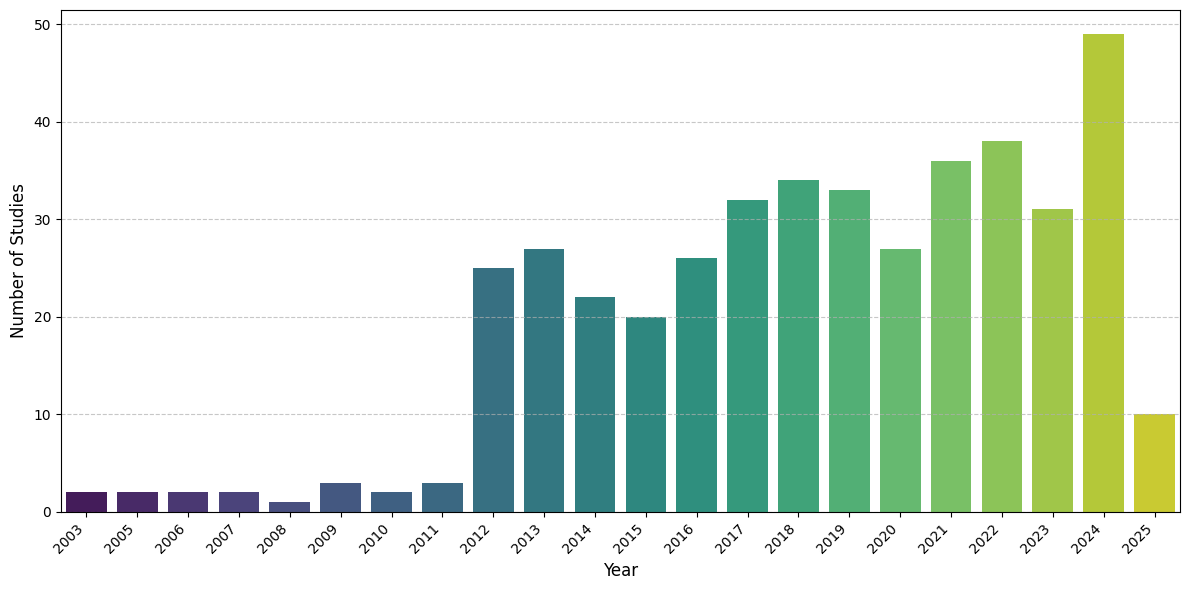

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn often makes matplotlib plots look nicer

# Load the dataset
try:
    df = pd.read_excel('data/merged_data.xlsx')
    print(len(df))
except FileNotFoundError:
    print("Error: 'data/merged_data.xls' not found. Please ensure the file is in the correct directory.")
    exit()

# --- 1. Yearly distribution of studies ---

# IMPORTANT: Replace 'Your_Year_Column_Name' with the actual column name for the year in your CSV.
# For example, if your column is named 'Publication Year', use df['Publication Year'].
year_column_name = 'YEAR' # <--- **UPDATE THIS**

if year_column_name not in df.columns:
    print(f"Error: Column '{year_column_name}' not found in the DataFrame. Please check the column name.")
else:
    # Ensure the year column is numeric and handle potential non-numeric entries (e.g., convert to int)
    # If your year column contains full dates, you'll need to extract the year first:
    # df['Year'] = pd.to_datetime(df[year_column_name]).dt.year

    # For now, let's assume it's directly convertible to integer year
    df[year_column_name] = pd.to_numeric(df[year_column_name], errors='coerce').astype('Int64') # 'Int64' allows for NaN

    # Drop rows where the year is NaN after conversion
    df_clean = df.dropna(subset=[year_column_name])

    # Calculate the frequency of each year
    yearly_counts = df_clean[year_column_name].value_counts().sort_index()

    # Create the plot
    plt.figure(figsize=(12, 6)) # Adjust figure size as needed
    sns.barplot(x=yearly_counts.index, y=yearly_counts.values, palette='viridis')

    # plt.title('Yearly Distribution of Studies', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Number of Studies', fontsize=12)
    plt.xticks(rotation=45, ha='right') # Rotate x-axis labels for better readability if many years
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout() # Adjust layout to prevent labels from overlapping
    plt.savefig("figs/yearly_distro.png", dpi=600)

    # print("\nYearly Distribution Data:")
    # print(yearly_counts)

#### 2. Study PDFs Automatic download

In [2]:
%pip install doi2pdf

Note: you may need to restart the kernel to use updated packages.


In [3]:
import requests
from bs4 import BeautifulSoup
import os

def download_pdf_from_scihub(doi, download_dir="pdfs/", scihub_mirror="https://sci-hub.st/"):
    """
    Attempts to download a PDF for a given DOI from Sci-Hub without dedicated libraries like PyPaperBot or doi2pdf.
    Uses requests for HTTP and BeautifulSoup for HTML parsing.

    Args:
        doi (str): The Digital Object Identifier (DOI) of the paper.
        download_dir (str): The directory where the PDF should be saved.
                            Defaults to the current directory.
        scihub_mirror (str): The URL of a working Sci-Hub mirror (e.g., "https://sci-hub.st/").
                             **Important: Sci-Hub mirrors change frequently. Verify it works in your browser.**
    """
    if not os.path.exists(download_dir):
        os.makedirs(download_dir)

    # Construct the Sci-Hub URL
    scihub_url = f"{scihub_mirror}{doi}"
    output_filename = os.path.join(download_dir, f"{doi.replace('/', '_').replace('.', '_')}.pdf")

    print(f"Attempting to access Sci-Hub at: {scihub_url}")

    try:
        # Step 1: Get the HTML content from Sci-Hub
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        response = requests.get(scihub_url, headers=headers, timeout=10)
        response.raise_for_status() # Raise an exception for HTTP errors (4xx or 5xx)

        soup = BeautifulSoup(response.text, 'html.parser')

        # Step 2: Try to find the PDF link
        pdf_link = None

        # Common strategy 1: Look for an iframe containing the PDF
        iframe = soup.find('iframe', id='pdf')
        if iframe and 'src' in iframe.attrs:
            pdf_link = iframe['src']
            if pdf_link.startswith('//'): # Handle protocol-relative URLs
                pdf_link = 'https:' + pdf_link
            print(f"Found PDF link in iframe: {pdf_link}")
        else:
            # Common strategy 2: Look for a direct link to a PDF file
            # This is often the "download" button or a direct embed.
            # Sci-Hub often serves the PDF via a direct link ending in .pdf
            for a_tag in soup.find_all('a', href=True):
                if '.pdf' in a_tag['href']:
                    pdf_link = a_tag['href']
                    if not pdf_link.startswith('http'): # Make sure it's an absolute URL
                        # Try to construct an absolute URL if it's relative
                        if pdf_link.startswith('//'):
                            pdf_link = 'https:' + pdf_link
                        else:
                            # This part is tricky; it assumes the PDF is hosted on the same domain as Sci-Hub
                            # For more robust solution, might need urljoin
                            pdf_link = scihub_mirror.rstrip('/') + pdf_link
                    print(f"Found direct PDF link: {pdf_link}")
                    break

        if not pdf_link:
            print("Could not find a PDF link on the Sci-Hub page.")
            print("This might mean the paper is not available, or the page structure has changed.")
            return

        # Step 3: Download the PDF
        if pdf_link.startswith('/'): # Sometimes links are relative to the domain
             pdf_link = f"{scihub_mirror.rstrip('/')}{pdf_link}"

        print(f"Downloading PDF from: {pdf_link}")
        pdf_response = requests.get(pdf_link, headers=headers, stream=True, timeout=30)
        pdf_response.raise_for_status()

        with open(output_filename, 'wb') as f:
            for chunk in pdf_response.iter_content(chunk_size=8192):
                f.write(chunk)
        print(f"Successfully downloaded PDF to: {output_filename}")

    except requests.exceptions.RequestException as e:
        print(f"Network or HTTP error: {e}")
        print("Check your internet connection or try a different Sci-Hub mirror.")
    except Exception as e:
        print(f"An unexpected error occurred: {e}")
        print("The Sci-Hub page structure might have changed, or the paper is not accessible.")


download_pdf_from_scihub("10.7196/SAMJ.7447")


Attempting to access Sci-Hub at: https://sci-hub.st/10.7196/SAMJ.7447
Could not find a PDF link on the Sci-Hub page.
This might mean the paper is not available, or the page structure has changed.


### V1 extracted data processing

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

v1_data = pd.read_csv("data/data.v1.csv")

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

In [5]:
len(v1_data)

NameError: name 'v1_data' is not defined

In [30]:
allowed_categories = ['An. funestus', 'funestus', 'a. funestus', 'an. funestus']
v1_data = v1_data[v1_data['vector_species'].isin(allowed_categories)]

In [31]:
v1_data_clean_lat_lon = v1_data.dropna(subset=['latitude','longitude'])

In [32]:
len(v1_data_clean_lat_lon)

122

In [33]:
v1_data_clean_lat_lon

,doc_id,vector_species,country,study_site,vector_control_method,biting_location,resting_location,disease,year,author,study_title,latitude,longitude,reported_insecticide_resistance,reported_insecticide_resistance_type,Unnamed: 15
4116,abc28fa2-c1bd-49c8-8d35-32a86bf3cbbd,an. funestus,NaN,mpumalanga province,indoor residual spraying irs,outdoor,NaN,malaria,2017,ashley burke,a new malaria vector mosquito in south africa,s25°42 ′ 03″,e31°48 ′ 31″,reported,NaN,NaN
4117,abc28fa2-c1bd-49c8-8d35-32a86bf3cbbd,an. funestus,NaN,mpumalanga province,indoor residual spraying irs,NaN,NaN,NaN,2017,ashley burke,study,s25°42 ′ 03″,e31°48 ′ 31″,reported,NaN,NaN
4118,abc28fa2-c1bd-49c8-8d35-32a86bf3cbbd,an. funestus,NaN,kwazulu-natal province kzn,ddt,outdoor,NaN,NaN,2017,leonard dandalo,study,s25°38 ′ 42″,e31°42 ′ 01″,reported,NaN,NaN
4119,abc28fa2-c1bd-49c8-8d35-32a86bf3cbbd,an. funestus,NaN,mpumalanga province,ddt,NaN,NaN,NaN,2017,leonard dandalo,study,s25°38 ′ 42″,e31°42 ′ 01″,reported,NaN,NaN
4120,abc28fa2-c1bd-49c8-8d35-32a86bf3cbbd,an. funestus,NaN,vlakbult,ddt,outdoor,NaN,NaN,2017,leonard dandalo,study,s27°23 ′ 50.5″,e032°12 ′ 20.1″,reported,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6853,79cadaa2-df04-40c3-a8d7-3770fe7ce45f,an. funestus,NaN,masogo,indoor residual spraying irs,indoors,NaN,malaria,2021,bernard abong’o,comparison of four outdoor mosquito trapping m...,0.16° s,35.19° e,NaN,NaN,NaN
6854,79cadaa2-df04-40c3-a8d7-3770fe7ce45f,an. funestus,NaN,masogo,indoor residual spraying irs,indoors,NaN,malaria,2021,bernard abong’o,comparison of four outdoor mosquito trapping m...,0.16° s,35.19° e,NaN,NaN,NaN
6855,79cadaa2-df04-40c3-a8d7-3770fe7ce45f,an. funestus,NaN,masogo,indoor residual spraying irs,indoors,NaN,malaria,2021,bernard abong’o,comparison of four outdoor mosquito trapping m...,0.16° s,35.19° e,NaN,NaN,NaN
6856,79cadaa2-df04-40c3-a8d7-3770fe7ce45f,an. funestus,NaN,masogo,indoor residual spraying irs,indoors,NaN,malaria,2021,bernard abong’o,comparison of four outdoor mosquito trapping m...,0.16° s,35.19° e,NaN,NaN,NaN


In [6]:
import re

def parse_coordinate_string(coord_str: str) -> float:
    """
    Parses a coordinate string and converts it to decimal degrees.

    This function prioritizes simpler decimal formats, then attempts DMS.

    Handles formats like:
    - Pure Decimal Degrees: e.g., "123.45", "-75.123"
    - Decimal Degrees with optional degree symbol and direction:
      e.g., "35.19° e", "0.16° s", "N 45.123", "W 100.5", "34.88°e", "34.88°w"
    - Degrees, Minutes, Seconds (DMS): e.g., "s25°38 ′ 42″", "e31°42 ′ 01″",
      "25°38'42\" S", "120°15'30\" E", "40°00'00\" N"

    For South ('S') latitudes and West ('W') longitudes, the resulting
    decimal degree value will be negative. For North ('N') latitudes and
    East ('E') longitudes, it will be positive.

    Args:
        coord_str (str): The coordinate string to parse.

    Returns:
        float: The coordinate in decimal degrees.

    Raises:
        ValueError: If the string format is not recognized or if a DMS
                    format is provided without a cardinal direction.
    """
    original_str = coord_str
    # Normalize the string: remove leading/trailing whitespace and convert to lowercase
    s = coord_str.strip().lower()

    # Helper function to determine the sign based on direction
    def _get_sign(direction: str) -> int:
        """Returns -1 for South/West, 1 for North/East, default to 1 if no direction."""
        if direction in ['s', 'w']:
            return -1
        elif direction in ['n', 'e']:
            return 1
        return 1 # Should not be reached if direction is properly handled by caller logic

    # --- Attempt 1: Parse Pure Decimal or Decimal Degrees with Optional Direction/Symbol ---
    # This regex is more specific for decimal numbers.
    # It captures:
    # 1. Optional leading direction
    # 2. The decimal number (can be negative, optional decimal part)
    # 3. Optional degree symbol '°'
    # 4. Optional trailing direction
    decimal_deg_pattern = re.compile(
        r"([nswe])?\s*(-?\d+\.?\d*)\s*(?:°)?\s*([nswe])?"
    )
    match = decimal_deg_pattern.match(s)

    if match:
        leading_dir, val_str, trailing_dir = match.groups()
        try:
            decimal_value = float(val_str)
        except ValueError:
            # If val_str couldn't be converted to float, it's not this pattern
            pass
        else:
            direction = leading_dir or trailing_dir
            if direction:
                return decimal_value * _get_sign(direction)
            else:
                # If no direction, and it matches this pattern, it's a pure decimal number
                return decimal_value

    # --- Attempt 2: Parse DMS (Degrees, Minutes, Seconds) format ---
    # This regex is designed to capture:
    # 1. Optional leading direction (n, s, w, e)
    # 2. Degrees (integer)
    # 3. Minutes (integer, ensures 0-59 with a slightly more restrictive pattern)
    # 4. Seconds (float, optional decimal part)
    # 5. Optional trailing direction
    # It explicitly looks for '′' or "'" for minutes and '″' or "\"" for seconds
    # to avoid false positives with decimal degrees.
    dms_pattern = re.compile(
        r"([nswe])?\s*(\d+)[°\s]*(\d+)[′']\s*(\d*\.?\d*)[″\"]?\s*([nswe])?"
    )
    match = dms_pattern.match(s)

    if match:
        leading_dir, deg_str, min_str, sec_str, trailing_dir = match.groups()

        degrees = int(deg_str)
        minutes = int(min_str)
        seconds = float(sec_str) if sec_str else 0.0

        # Validate minutes and seconds range for DMS
        if not (0 <= minutes < 60 and 0 <= seconds < 60):
            # If minutes or seconds are out of valid range (e.g., 88 minutes),
            # it's likely not DMS, so fall through to error
            pass # The previous decimal pattern should have caught it first if it was decimal

        direction = leading_dir or trailing_dir
        if not direction:
            raise ValueError(
                f"Direction (N/S/E/W) missing for DMS format: '{original_str}'. "
                "Cannot determine if it's North/South or East/West."
            )

        decimal_value = float(degrees) + float(minutes) / 60 + float(seconds) / 3600
        return decimal_value * _get_sign(direction)
    else:
        return 0
    # If no pattern matched, raise an error
    # raise ValueError(f"Unrecognized coordinate string format: '{original_str}'")

# --- Test Cases ---
print("--- Pure Decimal / Decimal Degrees with Direction/Symbol Tests (Prioritized) ---")
print(f"123.45 -> {parse_coordinate_string('123.45'):.6f}")
print(f"-75.123 -> {parse_coordinate_string('-75.123'):.6f}")
print(f"0.0 -> {parse_coordinate_string('0.0'):.6f}")
print(f"35.19° e -> {parse_coordinate_string('35.19° e'):.6f}")
print(f"0.16° s -> {parse_coordinate_string('0.16° s'):.6f}")
print(f"34.88°e -> {parse_coordinate_string('34.88°e'):.6f}") # Now handled correctly
print(f"34.88°w -> {parse_coordinate_string('34.88°w'):.6f}") # Now handled correctly
print(f"N 45.123 -> {parse_coordinate_string('N 45.123'):.6f}")
print(f"W 100.5 -> {parse_coordinate_string('W 100.5'):.6f}")
print(f"E 15.00 -> {parse_coordinate_string('E 15.00'):.6f}")
print(f"S 90.0 -> {parse_coordinate_string('S 90.0'):.6f}")
print(f"123.45° -> {parse_coordinate_string('123.45°'):.6f}")

print("\n--- DMS Format Tests (Attempted Second) ---")
print(f"s25°38 ′ 42″ -> {parse_coordinate_string('s25°38 ′ 42″'):.6f}")
print(f"e31°42 ′ 01″ -> {parse_coordinate_string('e31°42 ′ 01″'):.6f}")
print(f"25°38′42″ S -> {parse_coordinate_string('25°38′42″ S'):.6f}")
print(f"120°15'30\" E -> {parse_coordinate_string('120°15\'30" E'):.6f}")
print(f"40°00'00\" N -> {parse_coordinate_string('40°00\'00" N'):.6f}")
print(f"75°00'00\" W -> {parse_coordinate_string('75°00\'00" W'):.6f}")

print("\n--- Error Handling Tests ---")
try:
    parse_coordinate_string("invalid format string")
except ValueError as e:
    print(f"Error for 'invalid format string': {e}")

try:
    parse_coordinate_string("25°38′42″") # DMS without direction
except ValueError as e:
    print(f"Error for '25°38′42″' (DMS without direction): {e}")

--- Pure Decimal / Decimal Degrees with Direction/Symbol Tests (Prioritized) ---
123.45 -> 123.450000
-75.123 -> -75.123000
0.0 -> 0.000000
35.19° e -> 35.190000
0.16° s -> -0.160000
34.88°e -> 34.880000
34.88°w -> -34.880000
N 45.123 -> 45.123000
W 100.5 -> -100.500000
E 15.00 -> 15.000000
S 90.0 -> -90.000000
123.45° -> 123.450000

--- DMS Format Tests (Attempted Second) ---
s25°38 ′ 42″ -> -25.000000
e31°42 ′ 01″ -> 31.000000
25°38′42″ S -> 25.000000
120°15'30" E -> 120.000000
40°00'00" N -> 40.000000
75°00'00" W -> 75.000000

--- Error Handling Tests ---


In [7]:
def dms_to_decimal(str_value):
    # direction = str_value.split(" ")
    # degrees, minutes, seconds, direction
    # decimal_degrees = float(degrees) + float(minutes) / 60 + float(seconds) / 3600
    # if direction.upper() in ['S', 'W']:
    #     decimal_degrees *= -1
    return decimal_degrees

In [8]:
v1_data_clean_lat_lon['latitude'] = v1_data_clean_lat_lon['latitude'].apply(parse_coordinate_string)
v1_data_clean_lat_lon['longitude'] = v1_data_clean_lat_lon['longitude'].apply(parse_coordinate_string)

NameError: name 'v1_data_clean_lat_lon' is not defined

In [9]:
v1_data_clean_lat_lon.to_csv("data/clean_data_v1.csv")

NameError: name 'v1_data_clean_lat_lon' is not defined

### V2 Data cleaning

In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

v2_data = pd.read_csv("data/data.v2.csv")
len(v2_data)

24480

In [17]:
allowed_categories = [
    'Anopheles', 'anopheles', 'An. funestus', 'funestus', 
    'a. funestus', 'an. funestus', 'anopheles funestus', 
    'anopheles funestus s.s.', 'anopheles funestus complex',
    ' anopheles funestus', 'anopheles funestus s.l.', 'an. funestus s.s.',
    'an1funestus', 'anopheles funestus fumoz-r', 'a. funestus', 
    'anopheles funestus mosquitoes'
]
v2_data = v2_data[v2_data['vector_species'].isin(allowed_categories)]

In [18]:
v2_data_clean_lat_lon = v2_data.dropna(subset=['latitude','longitude'])
len(v2_data_clean_lat_lon)

4243

In [19]:
def uniform_vector_name(val):
    n = str(val).strip()
    n = n.replace("anopheles funestus", "an. funestus")
    if n == "anopheles":
        return "an. funestus"
    return n

def uniform_resistance_info(val):
    n = str(val).strip().lower()
    if "anopheles" in n:
        return None
    elif "pyrethroid" in n:
        return "pyrethroid resistance"
    elif "kdr" in n:
        return "kdr"
    elif "metabolic" in n:
        return "metabolic resistance"
    elif "ddt" in n:
        return "ddt resistance"
    elif "no" or "none" or "unkown" in n:
        return None
    elif "nan" in n:
        return None
    return n

def uniform_bitting_resting_info(val):
    n = str(val).lower()
    if "indoor" in n:
        return "indoor"
    elif "outdoor" in n:
        return "outdoor"
    elif "endoph" in n:
        return "endophilic"
    elif "exoph" in n:
        return "exophilic"
    elif "anthropo" in n:
        return "anthropophilic"
    elif "resting inside houses" in n:
        return "indoor"
    elif "resting behavior" in n:
        return None
    return n

v2_data_clean_lat_lon['latitude'] = v2_data_clean_lat_lon['latitude'].apply(parse_coordinate_string)
v2_data_clean_lat_lon['longitude'] = v2_data_clean_lat_lon['longitude'].apply(parse_coordinate_string)
v2_data_clean_lat_lon['vector_species'] = v2_data_clean_lat_lon['vector_species'].apply(uniform_vector_name)
v2_data_clean_lat_lon['reported_insecticide_resistance'] = v2_data_clean_lat_lon['reported_insecticide_resistance'].apply(uniform_resistance_info)
v2_data_clean_lat_lon['reported_insecticide_resistance_type'] = v2_data_clean_lat_lon['reported_insecticide_resistance_type'].apply(uniform_resistance_info)
v2_data_clean_lat_lon['biting_location'] = v2_data_clean_lat_lon['biting_location'].apply(uniform_bitting_resting_info)
v2_data_clean_lat_lon['resting_location'] = v2_data_clean_lat_lon['resting_location'].apply(uniform_bitting_resting_info)
v2_data_clean_lat_lon.to_csv("data/clean_data_v2.csv")

/tmp/ipykernel_1239669/3462966988.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v2_data_clean_lat_lon['latitude'] = v2_data_clean_lat_lon['latitude'].apply(parse_coordinate_string)
/tmp/ipykernel_1239669/3462966988.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  v2_data_clean_lat_lon['longitude'] = v2_data_clean_lat_lon['longitude'].apply(parse_coordinate_string)
/tmp/ipykernel_1239669/3462966988.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

Resistance by Vector (NaNs filled):
 reported_insecticide_resistance  Not Reported  ddt resistance  kdr  \
vector_species                                                       
an. funestus                             2810             133    2   
an. funestus complex                       79               0    0   
an. funestus s.l.                         102               0    0   
an. funestus s.s.                         330               2    0   

reported_insecticide_resistance  metabolic resistance  pyrethroid resistance  
vector_species                                                                
an. funestus                                      112                    663  
an. funestus complex                                0                      0  
an. funestus s.l.                                   0                      0  
an. funestus s.s.                                   0                     10  


<Figure size 1200x700 with 0 Axes>

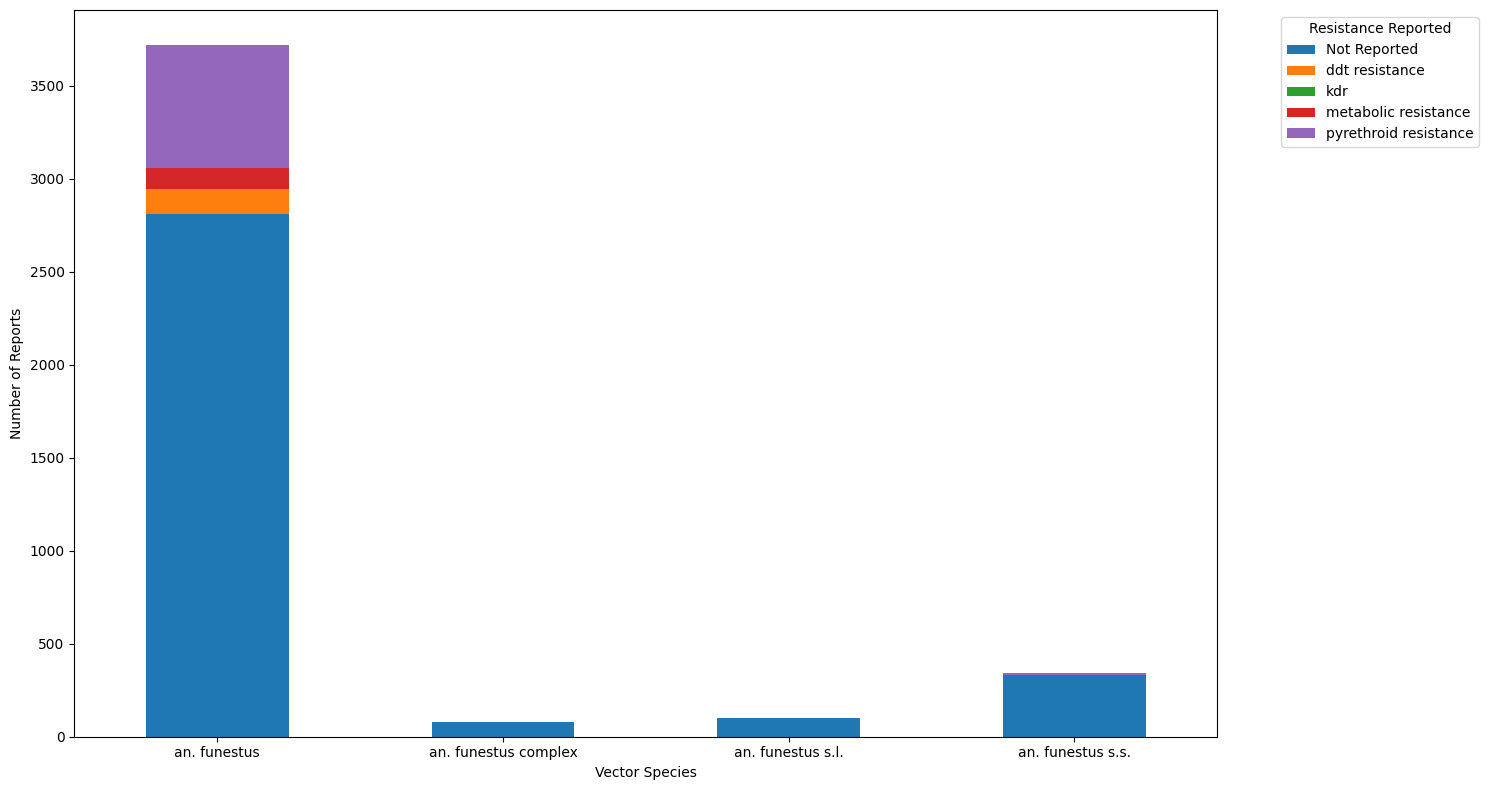


Biting Location by Vector (NaNs filled):
 biting_location       Unknown  alters to earlier host seeking  anthropophilic  \
vector_species                                                                  
an. funestus              868                              67              69   
an. funestus complex       79                               0               0   
an. funestus s.l.           0                               0               0   
an. funestus s.s.          53                               0              49   

biting_location       bite inside human dwellings  context  endophilic  \
vector_species                                                           
an. funestus                                   67       76          59   
an. funestus complex                            0        0           0   
an. funestus s.l.                               0        0           0   
an. funestus s.s.                               0        0           2   

biting_location       hum

<Figure size 1200x700 with 0 Axes>

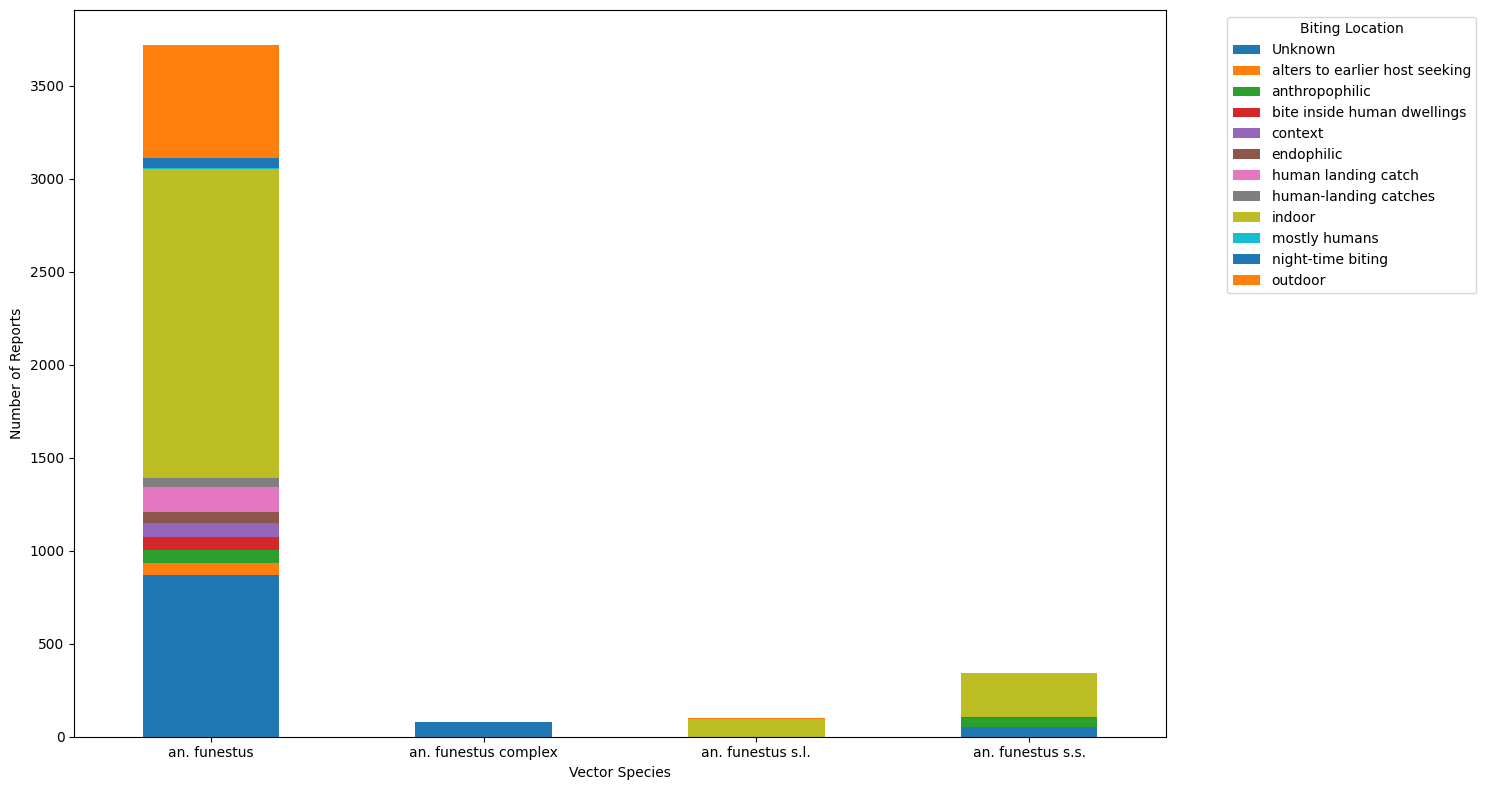


Resting Location by Vector (NaNs filled):
 resting_location      Unknown  endophilic  indoor  \
vector_species                                      
an. funestus             2071         307     885   
an. funestus complex       79           0       0   
an. funestus s.l.         102           0       0   
an. funestus s.s.         181          53     106   

resting_location      living/sleeping areas of houses huts  \
vector_species                                               
an. funestus                                           139   
an. funestus complex                                     0   
an. funestus s.l.                                        0   
an. funestus s.s.                                        0   

resting_location      not explicitly stated not explicitly stated  outdoor  
vector_species                                                              
an. funestus                                                   37      281  
an. funestus complex             

<Figure size 1200x700 with 0 Axes>

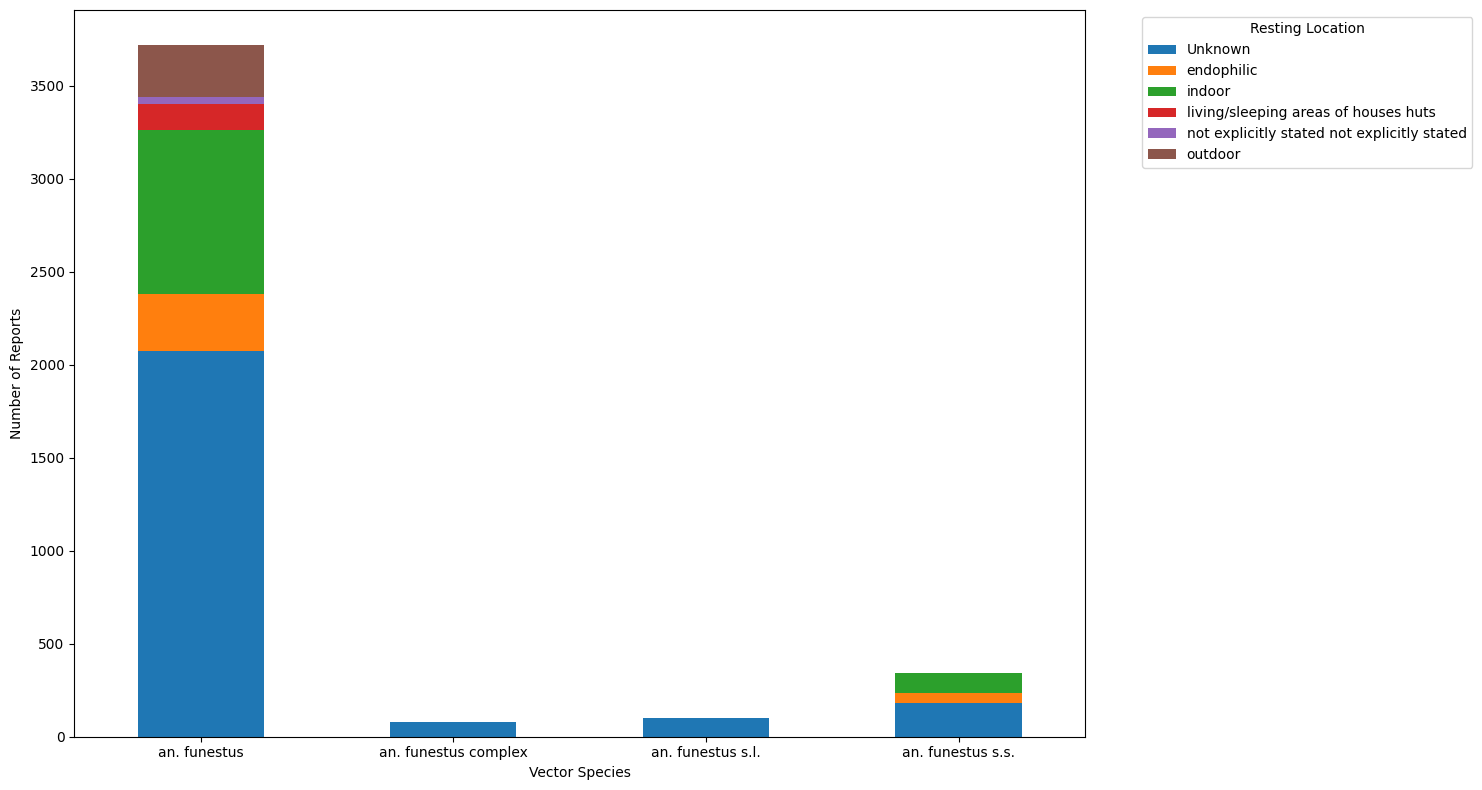

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('data/clean_data_v2.csv')

# Drop the 'Unnamed: 0' column as it is an index column and not required for the analysis
df = df.drop(columns=['Unnamed: 0'])

# --- Insight on resistance for each vector ---
# Fill NaN values in 'reported_insecticide_resistance' with 'Not Reported'
df['reported_insecticide_resistance'] = df['reported_insecticide_resistance'].fillna('Not Reported').astype(str)

# Group by 'vector_species' and 'reported_insecticide_resistance' to count occurrences
resistance_by_vector = df.groupby(['vector_species', 'reported_insecticide_resistance']).size().unstack(fill_value=0)

print("Resistance by Vector (NaNs filled):\n", resistance_by_vector)

# Plotting resistance by vector
plt.figure(figsize=(12, 7))
resistance_by_vector.plot(kind='bar', stacked=True, figsize=(15, 8))
# plt.title('Reported Insecticide Resistance by Vector Species')
plt.xlabel('Vector Species')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Resistance Reported', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('resistance_by_vector_filled_nan.png')
plt.show()

# --- Insight on biting for each vector ---
# Fill NaN values in 'biting_location' with 'Unknown'
df['biting_location'] = df['biting_location'].fillna('Unknown').astype(str)

# Group by 'vector_species' and 'biting_location' to count occurrences
biting_by_vector = df.groupby(['vector_species', 'biting_location']).size().unstack(fill_value=0)

print("\nBiting Location by Vector (NaNs filled):\n", biting_by_vector)

# Plotting biting location by vector
plt.figure(figsize=(12, 7))
biting_by_vector.plot(kind='bar', stacked=True, figsize=(15, 8))
# plt.title('Biting Location by Vector Species')
plt.xlabel('Vector Species')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Biting Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('biting_by_vector_filled_nan.png')
plt.show()

# --- Insight on resting for each vector ---
# Fill NaN values in 'resting_location' with 'Unknown'
df['resting_location'] = df['resting_location'].fillna('Unknown').astype(str)

# Group by 'vector_species' and 'resting_location'] to count occurrences
resting_by_vector = df.groupby(['vector_species', 'resting_location']).size().unstack(fill_value=0)

print("\nResting Location by Vector (NaNs filled):\n", resting_by_vector)

# Plotting resting location by vector
plt.figure(figsize=(12, 7))
resting_by_vector.plot(kind='bar', stacked=True, figsize=(15, 8))
# plt.title('Resting Location by Vector Species')
plt.xlabel('Vector Species')
plt.ylabel('Number of Reports')
plt.xticks(rotation=0, ha='center')
plt.legend(title='Resting Location', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('resting_by_vector_filled_nan.png')
plt.show()

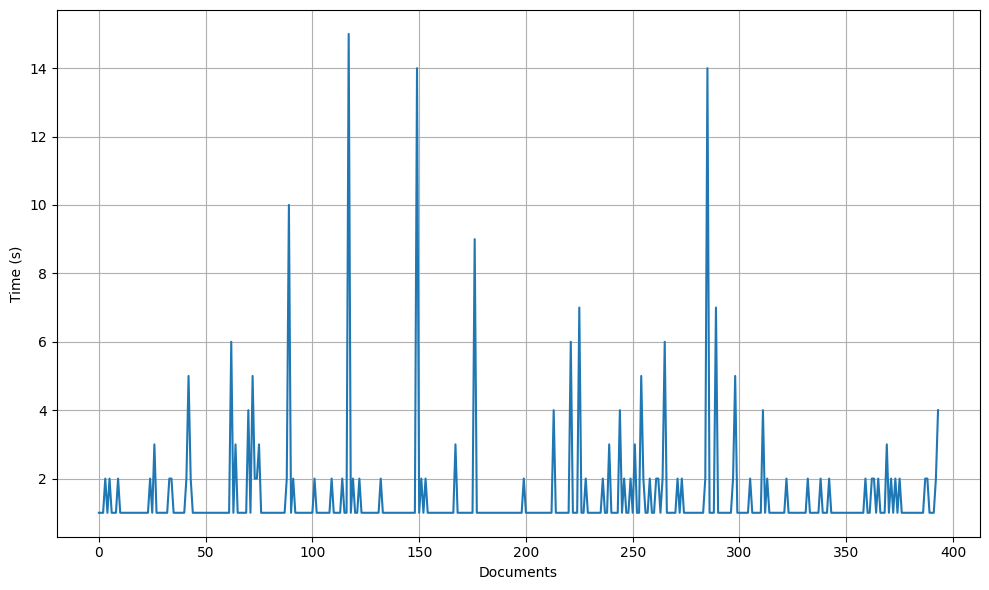

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/text_extraction_logs.csv')

# Get the index of the 'name' column (which is the DataFrame's index)
x_values = df.index

# Get the 'ts' column values
y_values = df['ts']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.xlabel('Documents')
plt.ylabel('Time (s)')
# plt.title('Plot of text extract')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('data/ts_vs_name_text_plot.png')


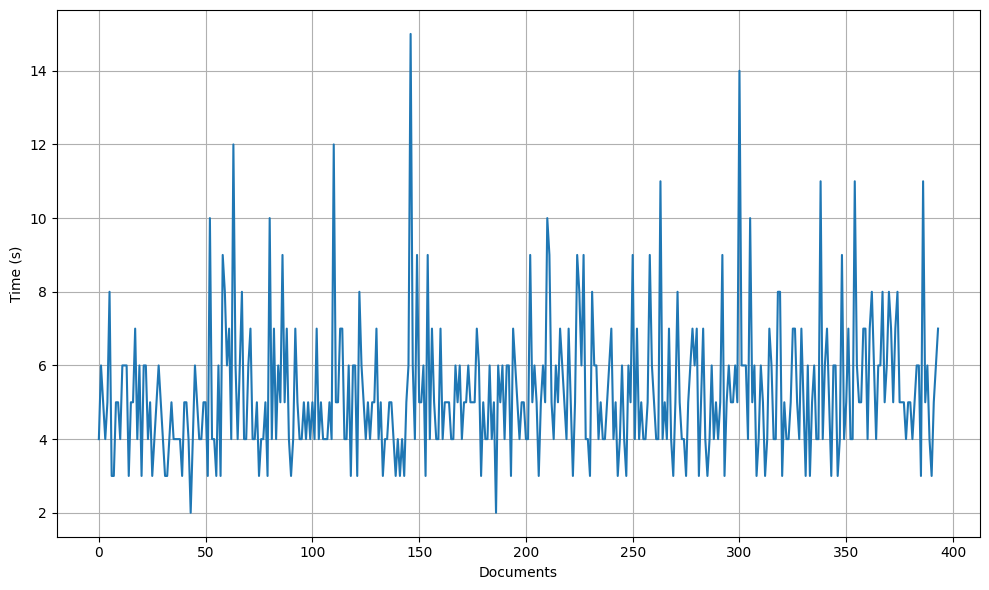

In [12]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/knowledge_extraction_logs.csv')

# Get the index of the 'name' column (which is the DataFrame's index)
x_values = df.index

# Get the 'ts' column values
y_values = df['ts']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.xlabel('Documents')
plt.ylabel('Time (s)')
# plt.title('Plot of text extract')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('data/ts_vs_name_knowledge_plot.png')


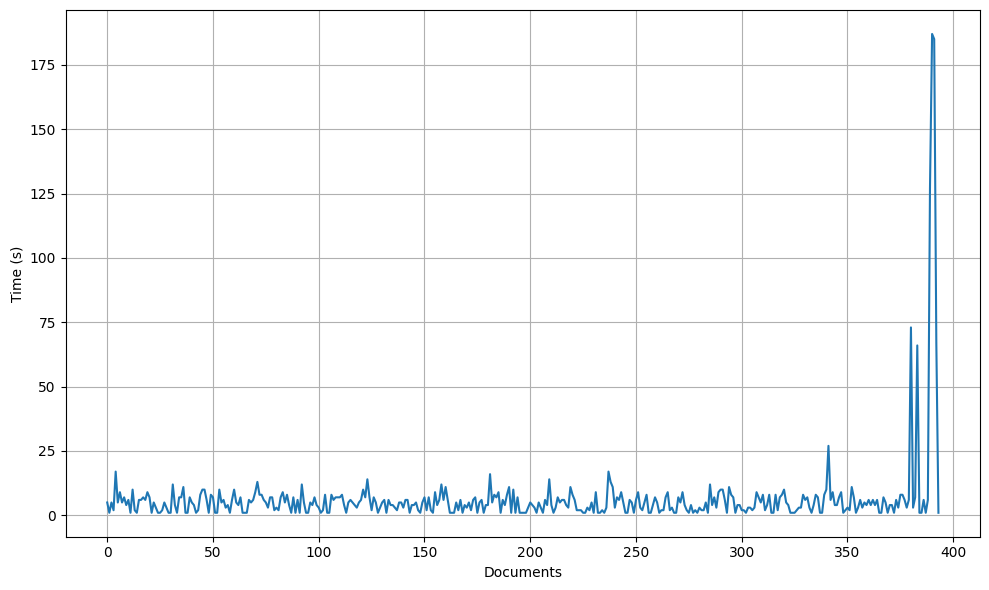

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('data/aligned_extraction_logs.csv')

# Get the index of the 'name' column (which is the DataFrame's index)
x_values = df.index

# Get the 'ts' column values
y_values = df['ts']

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(x_values, y_values)
plt.xlabel('Documents')
plt.ylabel('Time (s)')
# plt.title('Plot of text extract')
plt.grid(True)
plt.tight_layout()

# Save the plot
plt.savefig('data/ts_vs_name_aligned_plot.png')

### CENTROIDS COMPUTE AND COMPARISON

In [25]:
import numpy as np
import pandas as pd
import math
from math import radians, sin, cos, sqrt, atan2

def get_centroid(lat_list, lon_list):
    centroid_latitude = np.mean(lat_list)
    centroid_longitude = np.mean(lon_list)
    return centroid_latitude, centroid_longitude

def euclidian_distance(centroid1, centroid2):
    lat1, lon1 = centroid1
    lat2, lon2 = centroid2
    distance = math.sqrt((lat2 - lat1)**2 + (lon2 - lon1)**2)
    return distance

def haversine_distance(centroid1, centroid2):
    R = 6371  # Earth radius in kilometers
    lat1, lon1 = centroid1
    lat2, lon2 = centroid2
    # Convert coordinates from degrees to radians
    phi1 = radians(lat1)
    phi2 = radians(lat2)
    delta_phi = radians(lat2 - lat1)
    delta_lambda = radians(lon2 - lon1)
    a = sin(delta_phi / 2)**2 + cos(phi1) * cos(phi2) * sin(delta_lambda / 2)**2
    c = 2 * atan2(sqrt(a), sqrt(1 - a))
    distance = R * c
    return distance

In [30]:
# get auto data:
auto_data = pd.read_csv('data/clean_data_v2.csv')
# Drop the 'Unnamed: 0' column as it is an index column and not required for the analysis
auto_data = auto_data.drop(columns=['Unnamed: 0'])

In [31]:
# get manual data:
manual_data = pd.read_csv('data/filteredVAData.csv')

In [32]:
auto_centroid = get_centroid(list(auto_data['latitude']), list(auto_data['longitude']))
print(f" AUTO: --> LAT: {auto_centroid[0]}, LON: {auto_centroid[1]}")

 AUTO: --> LAT: 2.9273747643177, LON: 23.960156233749707


In [33]:
manual_centroid = get_centroid(list(manual_data['location_coordinates_1']), list(manual_data['location_coordinates_0']))
print(f" MANUAL: --> LAT: {manual_centroid[0]}, LON: {manual_centroid[1]}")

 MANUAL: --> LAT: -1.9093909111111107, LON: 25.712853314285713


In [34]:
distance = haversine_distance(auto_centroid, manual_centroid)
print(f" DISTANCE: {distance:.4f} km")

 DISTANCE: 572.0239 km
